<a href="https://colab.research.google.com/github/Bladimir0005/Entregable/blob/main/proyecto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
from google.colab import drive
import os
from google.colab import files
from collections import Counter
import shutil
import random
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16, ResNet50, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
# =============================
# PASO NUEVO A) Selector de modelo y normalización
# (No reemplaza nada de arriba; añade una capa configurable.)
# =============================
import tensorflow as tf

MODEL_NAME = globals().get("MODEL_NAME", "ResNet50")  # Puedes cambiar a 'VGG16', 'Xception'
INPUT_SIZE = globals().get("INPUT_SIZE", (224, 224))

from tensorflow.keras import applications

def get_model_and_preprocess(model_name: str):
    global INPUT_SIZE # Declare INPUT_SIZE as a global variable
    model_name = model_name.lower()
    if model_name == "resnet50":
        from tensorflow.keras.applications import ResNet50
        from tensorflow.keras.applications.resnet50 import preprocess_input
        base = ResNet50(weights="imagenet", include_top=False, input_shape=INPUT_SIZE + (3,))
        return base, preprocess_input
    elif model_name == "vgg16":
        from tensorflow.keras.applications import VGG16
        from tensorflow.keras.applications.vgg16 import preprocess_input
        base = VGG16(weights="imagenet", include_top=False, input_shape=INPUT_SIZE + (3,))
        return base, preprocess_input
    elif model_name == "xception":
        from tensorflow.keras.applications import Xception
        from tensorflow.keras.applications.xception import preprocess_input
        INPUT_SIZE = (299, 299)  # Xception/Inception requieren 299x299
        base = Xception(weights="imagenet", include_top=False, input_shape=INPUT_SIZE + (3,))
        return base, preprocess_input
    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

base_model_tmp, preprocess_input = get_model_and_preprocess(MODEL_NAME)
print(f"[INFO] Modelo seleccionado para normalización: {MODEL_NAME}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] Modelo seleccionado para normalización: ResNet50


In [4]:
drive.mount('/content/drive')

BASE_FOLDER = "/content/drive/MyDrive/Proyecto_Redes_Neuronales/"

# Nos aseguramos de que la carpeta exista, si no, la creamos.
import os
os.makedirs(BASE_FOLDER, exist_ok=True)
print(f"Carpeta de trabajo configurada en: {BASE_FOLDER}")

Mounted at /content/drive
Carpeta de trabajo configurada en: /content/drive/MyDrive/Proyecto_Redes_Neuronales/


In [5]:
# Subir y configurar el token de Kaggle
!pip install -q kaggle # Instala la librería de Kaggle

from google.colab import files
print("Por favor, sube el archivo 'kaggle.json' que descargaste de tu cuenta de Kaggle.")
files.upload()

# Movemos el token a la carpeta que Kaggle espera
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # Damos los permisos adecuados al archivo

print("\n¡Configuración de la API de Kaggle completada!")

Por favor, sube el archivo 'kaggle.json' que descargaste de tu cuenta de Kaggle.


Saving kaggle.json to kaggle.json

¡Configuración de la API de Kaggle completada!


In [6]:
# Descargar y descomprimir los datos

COMPETITION_NAME = 'plant-seedlings-classification'

# ==========================================================
# OPTIMIZACIÓN B: Descarga condicional del dataset
# ==========================================================
RAW_DATA_DIR = os.path.join(BASE_FOLDER, "raw_data")
os.makedirs(RAW_DATA_DIR, exist_ok=True)

if not os.path.exists(os.path.join(RAW_DATA_DIR, "train")):
    print(f"Descargando el dataset: {COMPETITION_NAME}...")
    !kaggle competitions download -c {COMPETITION_NAME} -p {BASE_FOLDER}
    print("\nDescomprimiendo archivo principal...")
    !unzip -o -q {BASE_FOLDER}/{COMPETITION_NAME}.zip -d {RAW_DATA_DIR}
else:
    print("Dataset ya existe, omitiendo descarga y descompresión.")


# En este caso, los datos están en una carpeta "train" ya descomprimida
print(f"\n¡Datos listos! Contenido de la carpeta '{RAW_DATA_DIR}':")
!ls {RAW_DATA_DIR}

print(f"\n¡Datos listos! Contenido de la carpeta '{RAW_DATA_DIR}':")
!ls {RAW_DATA_DIR}



Descargando el dataset: plant-seedlings-classification...
 99% 1.67G/1.69G [00:10<00:00, 153MB/s]
100% 1.69G/1.69G [00:10<00:00, 166MB/s]

Descomprimiendo archivo principal...

¡Datos listos! Contenido de la carpeta '/content/drive/MyDrive/Proyecto_Redes_Neuronales/raw_data':
sample_submission.csv  test  train

¡Datos listos! Contenido de la carpeta '/content/drive/MyDrive/Proyecto_Redes_Neuronales/raw_data':
sample_submission.csv  test  train


In [8]:
# ==========================================================
# OPTIMIZACIÓN: Crear estructura de directorios y dividir dataset
# ==========================================================

print("Iniciando la estructuración de directorios para el dataset de plántulas...")

# Change the current working directory to BASE_FOLDER
os.chdir(BASE_FOLDER)

# Directorio donde están las carpetas de clases
SOURCE_DIR = os.path.join('raw_data', 'train')

# Verificación rápida
if not os.path.isdir(SOURCE_DIR):
    raise FileNotFoundError(
        f"No existe el directorio de origen: {SOURCE_DIR}. "
        "Asegúrate de haber descargado y descomprimido correctamente los datos."
    )

# Directorio base de salida
STRUCTURED_DATA_DIR = 'data_structured'
TRAIN_DIR = os.path.join(STRUCTURED_DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(STRUCTURED_DATA_DIR, 'validation')
TEST_DIR = os.path.join(STRUCTURED_DATA_DIR, 'test')

# Proporciones de división
TRAIN_SPLIT = 0.7
VALIDATION_SPLIT = 0.15

# Clases = nombres de carpetas
CLASSES = [cls for cls in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, cls))]

# ✅ Mejor práctica: sólo borrar si quieres regenerar
if not os.path.exists(STRUCTURED_DATA_DIR):
    print("Creando nueva estructura de carpetas...")
    for base_dir in [TRAIN_DIR, VALIDATION_DIR, TEST_DIR]:
        for cls in CLASSES:
            os.makedirs(os.path.join(base_dir, cls), exist_ok=True)
else:
    print("Estructura existente detectada, omitiendo recreación.")

# Dividir y copiar los archivos (o enlazarlos si prefieres)
from tqdm import tqdm  # muestra barra de progreso

for cls in CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    random.seed(42)
    random.shuffle(images)

    n = len(images)
    train_end = int(n * TRAIN_SPLIT)
    val_end = int(n * (TRAIN_SPLIT + VALIDATION_SPLIT))

    splits = {
        TRAIN_DIR: images[:train_end],
        VALIDATION_DIR: images[train_end:val_end],
        TEST_DIR: images[val_end:]
    }

    for dest_root, file_list in splits.items():
        for f in tqdm(file_list, desc=f"Copiando {cls} → {os.path.basename(dest_root)}"):
            src = os.path.join(class_path, f)
            dst = os.path.join(dest_root, cls, f)
            if not os.path.exists(dst):  # no volver a copiar si ya está
                shutil.copy2(src, dst)

print("\n✅ ¡Estructura de directorios lista!")
for cls in CLASSES:
    print(f" {cls}:")
    print(f"  Entrenamiento: {len(os.listdir(os.path.join(TRAIN_DIR, cls)))} imágenes")
    print(f"  Validación:    {len(os.listdir(os.path.join(VALIDATION_DIR, cls)))} imágenes")
    print(f"  Test:          {len(os.listdir(os.path.join(TEST_DIR, cls)))} imágenes")

Iniciando la estructuración de directorios para el dataset de plántulas...
Creando nueva estructura de carpetas...


Copiando Sugar beet → test: 100%|██████████| 58/58 [00:00<00:00, 68.88it/s]



✅ ¡Estructura de directorios lista!
 Black-grass:
  Entrenamiento: 184 imágenes
  Validación:    39 imágenes
  Test:          40 imágenes
 Charlock:
  Entrenamiento: 273 imágenes
  Validación:    58 imágenes
  Test:          59 imágenes
 Cleavers:
  Entrenamiento: 200 imágenes
  Validación:    43 imágenes
  Test:          44 imágenes
 Common Chickweed:
  Entrenamiento: 427 imágenes
  Validación:    92 imágenes
  Test:          92 imágenes
 Common wheat:
  Entrenamiento: 154 imágenes
  Validación:    33 imágenes
  Test:          34 imágenes
 Fat Hen:
  Entrenamiento: 332 imágenes
  Validación:    71 imágenes
  Test:          72 imágenes
 Loose Silky-bent:
  Entrenamiento: 457 imágenes
  Validación:    98 imágenes
  Test:          99 imágenes
 Maize:
  Entrenamiento: 154 imágenes
  Validación:    33 imágenes
  Test:          34 imágenes
 Scentless Mayweed:
  Entrenamiento: 361 imágenes
  Validación:    77 imágenes
  Test:          78 imágenes
 Shepherds Purse:
  Entrenamiento: 161 imáge

In [9]:
# ==========================================================
# OPTIMIZACIÓN: Callbacks, pérdida y scheduler
# ==========================================================

import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Semilla para reproducibilidad
tf.random.set_seed(42)

# Carpeta de checkpoints (en Drive o proyecto)
CHECKPOINT_DIR = os.path.join(BASE_FOLDER, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Parada temprana y guardado automático
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,                 # un poco más tolerante
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=os.path.join(CHECKPOINT_DIR, 'model_{epoch:02d}.keras'),
        monitor='val_loss',
        save_best_only=False,       # guarda todas las épocas
        save_freq='epoch',
        verbose=1
    )
]

# Label Smoothing (reduce sobreajuste en clasificación)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Learning Rate Scheduler (Exponential Decay)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

# Optimizer con scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [12]:
# ==========================================================
# ENTRENAMIENTO TRANSFER LEARNING (ADAPTADO Y OPTIMIZADO)
# ==========================================================

import tensorflow as tf
from tensorflow.keras import layers, optimizers, regularizers
import pickle, os, gc

def build_model(base_model, input_shape, num_classes):
    """Construye un modelo de transferencia con regularización."""
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)


def train_transfer_model(base_model_class, preprocess_input_func, model_name,
                         input_shape=(224, 224, 3),batch_size =32 ):
    print(f"\n{'='*60}\n--- Iniciando entrenamiento para: {model_name} ---\n{'='*60}")

    tf.keras.backend.clear_session()
    gc.collect()

    num_classes = len(os.listdir(TRAIN_DIR))

    # === Generadores ===
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    )
    validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR, target_size=(input_shape[0], input_shape[1]),
        batch_size=BATCH_SIZE, class_mode='categorical'
    )
    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR, target_size=(input_shape[0], input_shape[1]),
        batch_size=BATCH_SIZE, class_mode='categorical'
    )

    # === Checkpoints específicos por modelo ===
    model_ckpt_dir = os.path.join(BASE_FOLDER, f"checkpoints_{model_name}")
    os.makedirs(model_ckpt_dir, exist_ok=True)
    ckpt_path = os.path.join(model_ckpt_dir, "model_{epoch:02d}.keras")

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path,
        save_weights_only=False,
        save_freq='epoch',
        verbose=1
    )

    # === Fase 1: Extracción de características ===
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = build_model(base_model, input_shape, num_classes)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule),
                  loss=loss_fn, metrics=['accuracy'])

    history_extraction = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS_FEATURE_EXTRACTION,
        callbacks=[*callbacks, checkpoint_cb]
    )

    # === Fase 2: Fine-tuning ===
    base_model.trainable = True
    fine_tune_at = max(0, len(base_model.layers) - 10)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    print(f"Descongeladas las últimas {len(base_model.layers) - fine_tune_at} capas del modelo base.")

    fine_tune_lr = 1e-5
    model.compile(optimizer=optimizers.Adam(learning_rate=fine_tune_lr),
                  loss=loss_fn, metrics=['accuracy'])

    history_fine_tune = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS_FINE_TUNING,
        callbacks=[*callbacks, checkpoint_cb]
    )

    # === Guardado del modelo y métricas ===
    final_model_path = os.path.join(BASE_FOLDER, f"{model_name}_final.keras")
    model.save(final_model_path)
    print(f"✅ Modelo final guardado en: {final_model_path}")

    # Guardar historial de ambas fases
    hist_path = os.path.join(BASE_FOLDER, f"{model_name}_history.pkl")
    with open(hist_path, "wb") as f:
        pickle.dump({
            "feature_extraction": history_extraction.history,
            "fine_tuning": history_fine_tune.history
        }, f)
    print(f"📊 Historial de entrenamiento guardado en: {hist_path}")

    print(f"--- Entrenamiento para {model_name} completado ---")
    return model, history_extraction, history_fine_tune, num_classes


In [17]:
# ==========================================================
# UTILIDAD: visualizar curvas de entrenamiento por fases
# ==========================================================
import matplotlib.pyplot as plt
import os

def plot_history(history_extraction, history_fine_tune, model_name, save_dir=None):
    # Acepta objetos History o dicts
    h1 = history_extraction.history if hasattr(history_extraction, "history") else history_extraction
    h2 = history_fine_tune.history if hasattr(history_fine_tune, "history") else history_fine_tune

    # Longitudes para colocar la línea vertical
    n1 = len(h1.get("accuracy", []))
    n2 = len(h2.get("accuracy", []))

    plt.figure(figsize=(16, 6))
    plt.suptitle(f'Curvas de Aprendizaje para {model_name}', fontsize=16)

    # --- Precisión ---
    plt.subplot(1, 2, 1)
    if "accuracy" in h1: plt.plot(h1["accuracy"], label="Train (Extracción)")
    if "val_accuracy" in h1: plt.plot(h1["val_accuracy"], label="Val (Extracción)")
    if "accuracy" in h2: plt.plot(range(n1, n1 + n2), h2["accuracy"], label="Train (Fine-tune)")
    if "val_accuracy" in h2: plt.plot(range(n1, n1 + len(h2["val_accuracy"])), h2["val_accuracy"], label="Val (Fine-tune)")
    if n1 > 0: plt.axvline(x=n1 - 1, linestyle="--", color="gray", label="Inicio Fine-tune")
    plt.title("Precisión"); plt.xlabel("Épocas"); plt.ylabel("Accuracy"); plt.legend()

    # --- Pérdida ---
    plt.subplot(1, 2, 2)
    if "loss" in h1: plt.plot(h1["loss"], label="Train (Extracción)")
    if "val_loss" in h1: plt.plot(h1["val_loss"], label="Val (Extracción)")
    if "loss" in h2: plt.plot(range(n1, n1 + len(h2["loss"])), h2["loss"], label="Train (Fine-tune)")
    if "val_loss" in h2: plt.plot(range(n1, n1 + len(h2.get("val_loss", []))), h2.get("val_loss", []), label="Val (Fine-tune)")
    if n1 > 0: plt.axvline(x=n1 - 1, linestyle="--", color="gray", label="Inicio Fine-tune")
    plt.title("Pérdida"); plt.xlabel("Épocas"); plt.ylabel("Loss"); plt.legend()

    plt.tight_layout()
    if save_dir is None:
        try:
            save_dir = BASE_FOLDER
        except NameError:
            save_dir = "."
    os.makedirs(save_dir, exist_ok=True)
    out_path = os.path.join(save_dir, f"{model_name}_learning_curves.png")
    plt.savefig(out_path, dpi=120, bbox_inches="tight")
    plt.show()
    print(f"📈 Curvas guardadas en: {out_path}")


[INFO] Parámetros globales definidos correctamente.

🚀 Entrenando arquitectura: VGG16

--- Iniciando entrenamiento para: VGG16 ---
Found 3319 images belonging to 12 classes.
Found 711 images belonging to 12 classes.
Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.3121 - loss: 2.6566
Epoch 1: saving model to /content/drive/MyDrive/Proyecto_Redes_Neuronales/checkpoints/model_01.keras

Epoch 1: saving model to resultados_transfer/checkpoints_VGG16/model_01.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 104s 966ms/step - accuracy: 0.3130 - loss: 2.6537 - val_accuracy: 0.5767 - val_loss: 1.9471
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.6231 - loss: 1.8144
Epoch 2: saving model to /content/drive/MyDrive/Proyecto_Redes_Neuronales/checkpoints/model_02.keras

Epoch 2: saving model to resultados_transfer/checkpoints_VGG16/model_02.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 97s 934ms/step - accuracy: 0.6232 - loss: 1.8141 - val_accuracy: 0.6498 - val_loss: 1.7200
Epoch 3

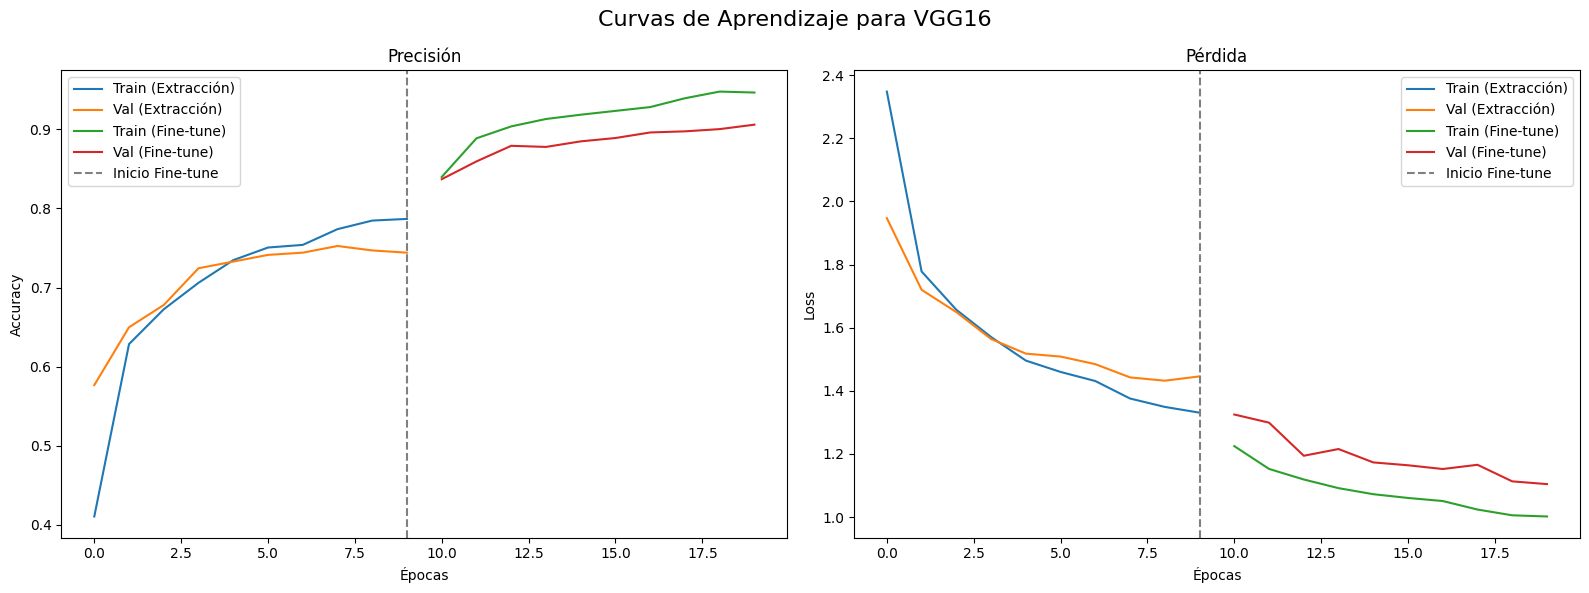

📈 Curvas guardadas en: resultados_transfer/VGG16_learning_curves.png
✅ Modelo VGG16 guardado en resultados_transfer/vgg16_model_final.keras

🚀 Entrenando arquitectura: ResNet50

--- Iniciando entrenamiento para: ResNet50 ---
Found 3319 images belonging to 12 classes.
Found 711 images belonging to 12 classes.
Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.4360 - loss: 2.6710
Epoch 1: saving model to /content/drive/MyDrive/Proyecto_Redes_Neuronales/checkpoints/model_01.keras

Epoch 1: saving model to resultados_transfer/checkpoints_ResNet50/model_01.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.4372 - loss: 2.6676 - val_accuracy: 0.6821 - val_loss: 1.7941
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.7089 - loss: 1.8648
Epoch 2: saving model to /content/drive/MyDrive/Proyecto_Redes_Neuronales/checkpoints/model_02.keras

Epoch 2: saving model to resultados_transfer/checkpoints_ResNet50/model_02.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 9

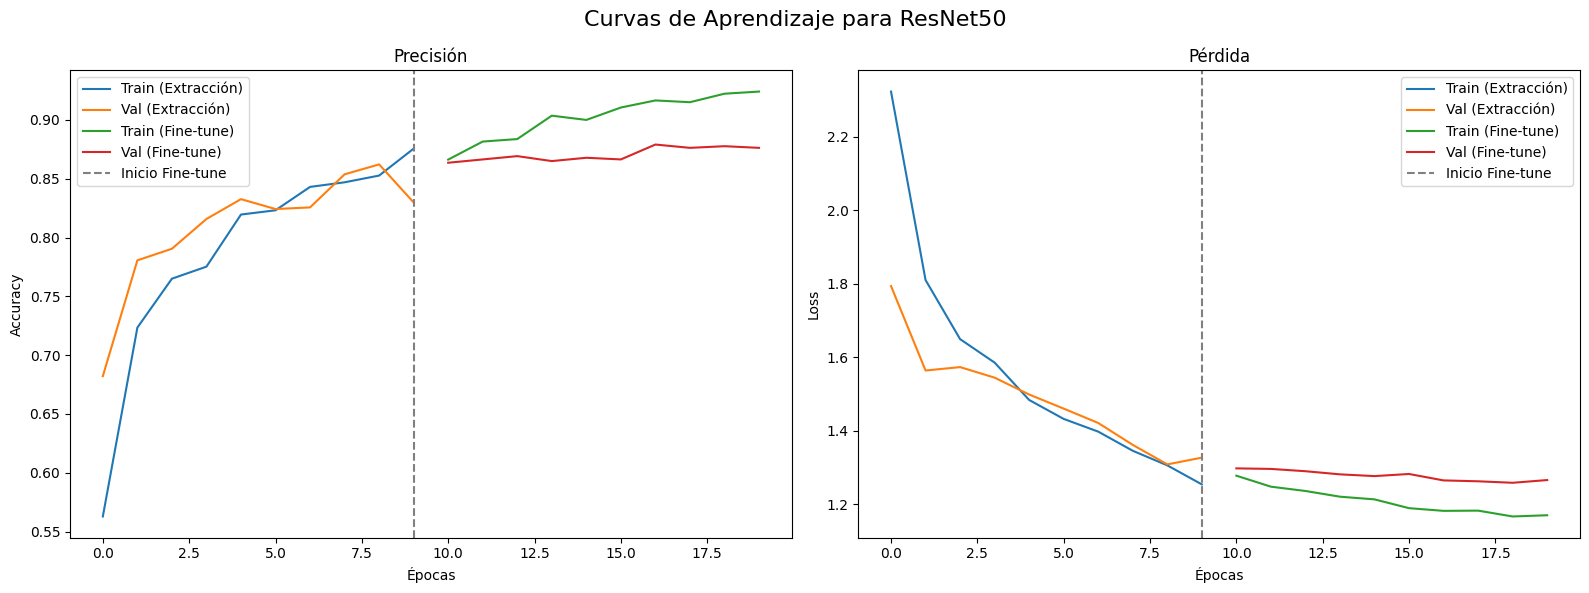

📈 Curvas guardadas en: resultados_transfer/ResNet50_learning_curves.png
✅ Modelo ResNet50 guardado en resultados_transfer/resnet50_model_final.keras

🚀 Entrenando arquitectura: Xception

--- Iniciando entrenamiento para: Xception ---
Found 3319 images belonging to 12 classes.
Found 711 images belonging to 12 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.3490 - loss: 3.0151
Epoch 1: saving model to /content/drive/MyDrive/Proyecto_Redes_Neuronales/checkpoints/model_01.keras

Epoch 1: saving model to resultados_transfer/checkpoints_Xception/model_01.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.3499 - loss: 3.0117 - val_accuracy: 0.5851 - val_loss: 2.1218
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.5808 - loss: 2.1830
Epoch 2: saving model to /content/drive/MyDrive/Proyecto_Redes_Neuronales/checkpoints/model_02.keras

Epoch 2: saving model to resultados_transfer/checkp

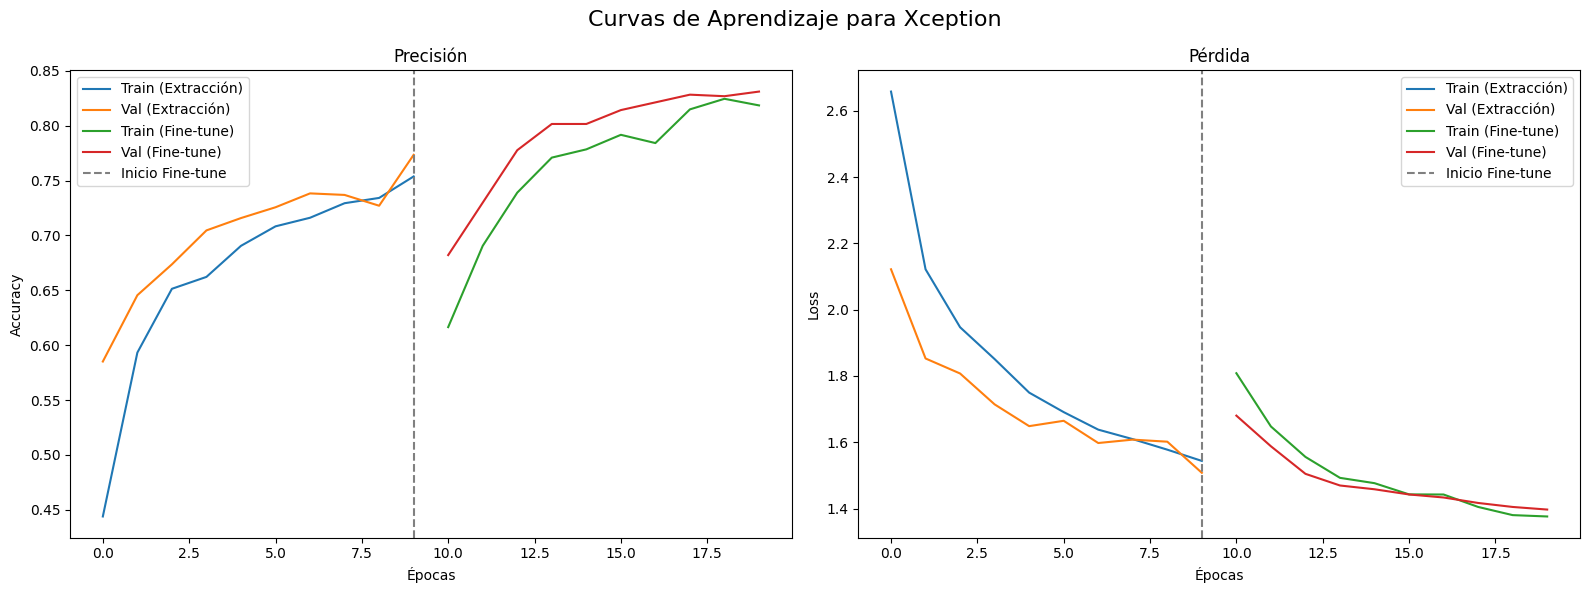

📈 Curvas guardadas en: resultados_transfer/Xception_learning_curves.png
✅ Modelo Xception guardado en resultados_transfer/xception_model_final.keras

✅ Entrenamiento de todas las arquitecturas completado.


In [18]:
# ==========================================================
# ENTRENAMIENTO DE TODAS LAS ARQUITECTURAS (OPTIMIZADO)
# ==========================================================

import gc
import tensorflow as tf
import os
import pickle

# ==========================================================
# PARÁMETROS GLOBALES DEL ENTRENAMIENTO
# ==========================================================
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS_FEATURE_EXTRACTION = 10
EPOCHS_FINE_TUNING = 10
BASE_FOLDER = "resultados_transfer"
os.makedirs(BASE_FOLDER, exist_ok=True)

print("[INFO] Parámetros globales definidos correctamente.")

results = {}

architectures = {
    "VGG16":    (VGG16, tf.keras.applications.vgg16.preprocess_input),
    "ResNet50": (ResNet50, tf.keras.applications.resnet50.preprocess_input),
    "Xception": (Xception, tf.keras.applications.xception.preprocess_input),
}

for name, (model_class, preprocess_func) in architectures.items():
    print(f"\n🚀 Entrenando arquitectura: {name}\n" + "="*60)

    # === Evitar errores si Colab se desconecta ===
    model_path = os.path.join(BASE_FOLDER, f"{name.lower()}_model_final.keras")
    history_path = os.path.join(BASE_FOLDER, f"{name}_history.pkl")

    # Si ya existe el modelo, lo omitimos
    if os.path.exists(model_path):
        print(f"⚠️ Modelo {name} ya entrenado previamente. Saltando...")
        continue

    # === Limpieza de sesión y memoria ===
    tf.keras.backend.clear_session()
    gc.collect()

    try:
        model, hist_ext, hist_ft, _ = train_transfer_model(model_class, preprocess_func, name, batch_size = 32)
        results[name] = {
            'model': model,
            'history_extraction': hist_ext.history,
            'history_fine_tune': hist_ft.history
        }

        # Guardar historial global en Drive
        with open(history_path, "wb") as f:
            pickle.dump(results[name], f)

        # Graficar resultados
        plot_history(hist_ext, hist_ft, name)

        # Guardar modelo final (ya lo hace la función, pero aseguramos copia)
        model.save(model_path)
        print(f"✅ Modelo {name} guardado en {model_path}")

    except Exception as e:
        print(f"❌ Error durante el entrenamiento de {name}: {e}")
        continue

print("\n✅ Entrenamiento de todas las arquitecturas completado.")






--- Evaluación Final en el Conjunto de Prueba ---

 Evaluando modelo: VGG16
Found 720 images belonging to 12 classes.
📊 Reporte de clasificación guardado en: resultados_transfer/VGG16_classification_report.json


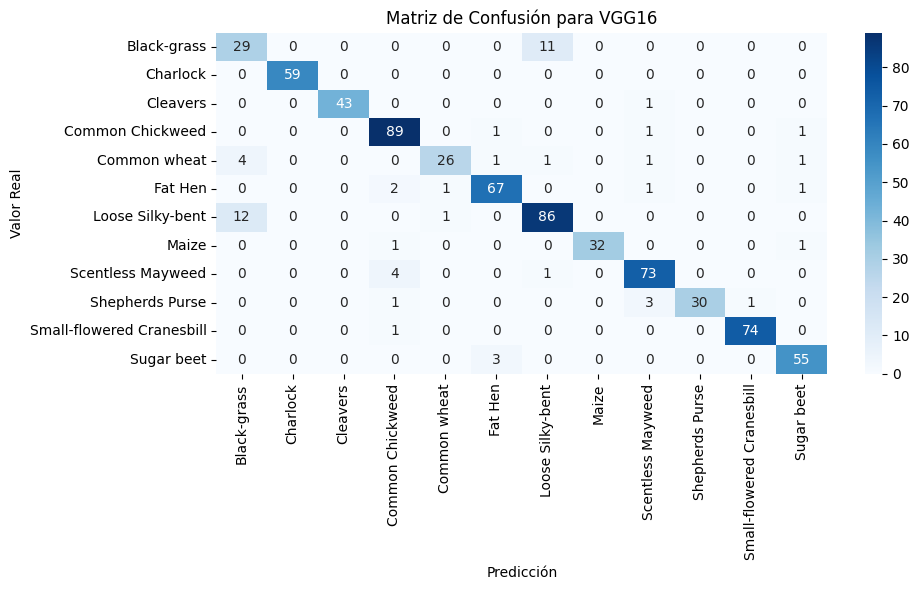


 Evaluando modelo: ResNet50
Found 720 images belonging to 12 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


📊 Reporte de clasificación guardado en: resultados_transfer/ResNet50_classification_report.json


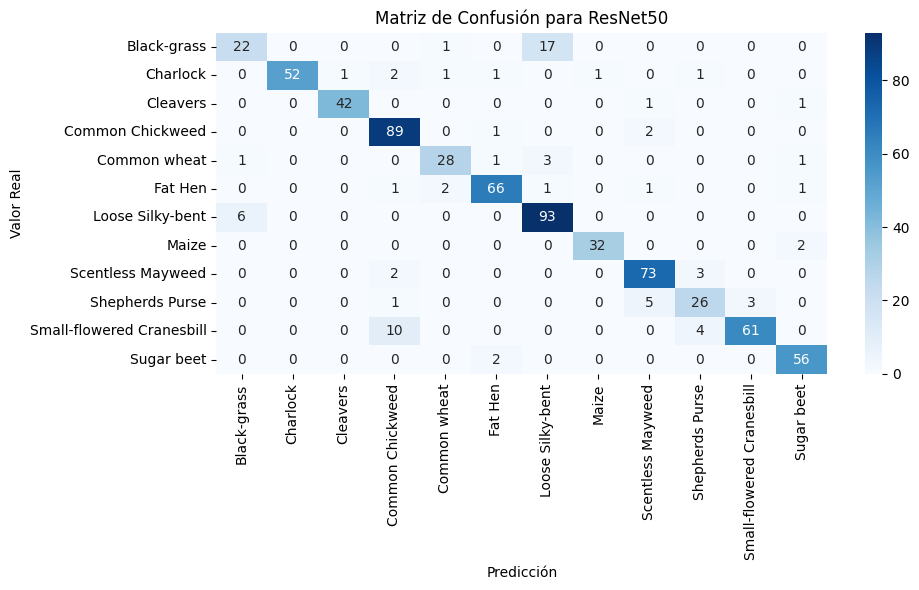


 Evaluando modelo: Xception
Found 720 images belonging to 12 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


📊 Reporte de clasificación guardado en: resultados_transfer/Xception_classification_report.json


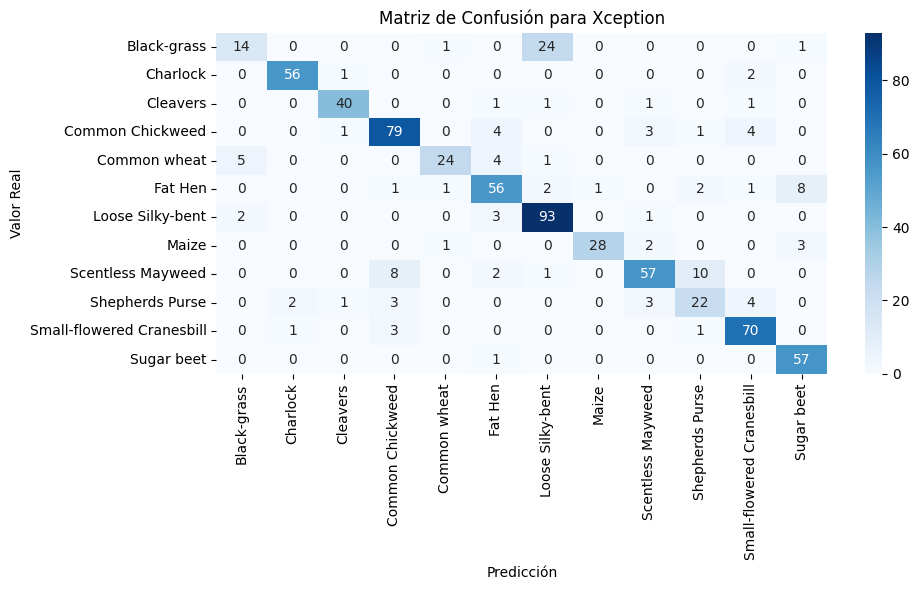


✅ Resultados guardados en 'resultados_transfer/resultados_comparacion.csv'


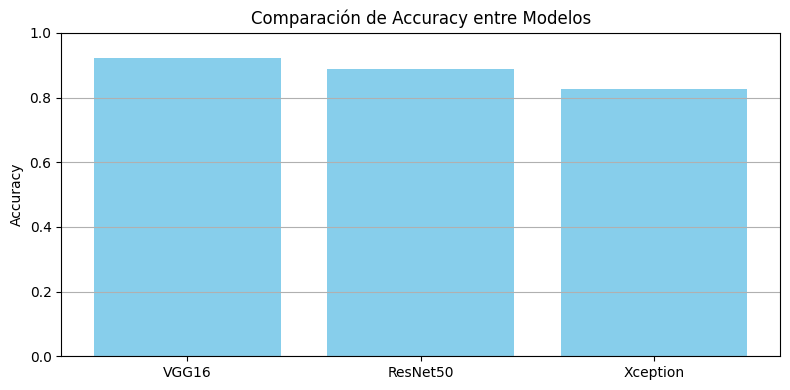


✅ Evaluación final completada.


In [19]:
# ==========================================================
# EVALUACIÓN FINAL DE TODAS LAS ARQUITECTURAS (OPTIMIZADA)
# ==========================================================
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import gc, os, json
from datetime import datetime

print(f"\n{'='*60}\n--- Evaluación Final en el Conjunto de Prueba ---\n{'='*60}")

metricas = []

# Si el diccionario results no existe (por reinicio), lo reconstruimos desde los modelos guardados
if "results" not in locals():
    results = {}
    for name in ["VGG16", "ResNet50", "Xception"]:
        model_path = os.path.join(BASE_FOLDER, f"{name.lower()}_model_final.keras")
        if os.path.exists(model_path):
            results[name] = {'model': tf.keras.models.load_model(model_path)}
            print(f"🔁 Modelo {name} cargado desde disco.")

# === Evaluación por modelo ===
for name, data in results.items():
    print(f"\n Evaluando modelo: {name}")

    tf.keras.backend.clear_session()
    gc.collect()

    preprocess_func = architectures[name][1]
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Evaluación básica
    loss, accuracy = data['model'].evaluate(test_generator, verbose=0)
    results[name]['test_accuracy'] = accuracy
    results[name]['test_loss'] = loss

    # Predicciones
    y_true = test_generator.classes
    y_pred_probs = data['model'].predict(test_generator, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    class_labels = list(test_generator.class_indices.keys())

    # Reporte de clasificación
    report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0, output_dict=True)
    report_path = os.path.join(BASE_FOLDER, f"{name}_classification_report.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=4)
    print(f"📊 Reporte de clasificación guardado en: {report_path}")

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels,
                yticklabels=class_labels, cmap="Blues")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.title(f"Matriz de Confusión para {name}")
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_FOLDER, f"{name}_confusion_matrix.png"))
    plt.show()

    # Agregar métricas principales
    metricas.append({
        "Modelo": name,
        "Accuracy": accuracy,
        "Loss": loss,
        "Precision_media": report["weighted avg"]["precision"],
        "Recall_media": report["weighted avg"]["recall"],
        "F1_media": report["weighted avg"]["f1-score"]
    })

# === Guardar métricas consolidadas ===
metrics_df = pd.DataFrame(metricas)
metrics_path = os.path.join(BASE_FOLDER, "resultados_comparacion.csv")
metrics_df.to_csv(metrics_path, index=False)
print(f"\n✅ Resultados guardados en '{metrics_path}'")

# === Gráfico comparativo ===
plt.figure(figsize=(8, 4))
plt.bar(metrics_df["Modelo"], metrics_df["Accuracy"], color='skyblue')
plt.ylim(0, 1)
plt.title("Comparación de Accuracy entre Modelos")
plt.ylabel("Accuracy")
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(BASE_FOLDER, f"comparacion_accuracy_{datetime.now().strftime('%H%M%S')}.png"))
plt.show()

print("\n✅ Evaluación final completada.")
